# Graficador de DCM (isócronas)

Cambiar los nombres para:
* Cúmulo
* Isócronas (ajustada y las "de error")

Indicar valores encontrados por el ajuste para:
* Enrojecimiento
* Módulo de distancia

Introducir las tablas de datos (archivos CSV guardados desde Topcat):
* Búsqueda realizada para el cúmulo
* Iśocrona adoptada
* 2 isócronas envolventes

Definir subconjuntos:
* Comoving
* Cluster
* GD (va a ser el subconjunto final, la selección de miembros última, va a llevar el nombre del Cúmulo)

Modificar en caso de ser necesario:
* Número de bines del histograma de paralaje
* Límites del DCM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.stats import norm

In [5]:
#Leer todas las isócronas:
lista = [f for f in os.listdir('Isocronas_tabla') if f.endswith('tabla.dat')]

# Leer cada archivo en un DataFrame y guardarlos en una lista
tablas = []
for archivo in lista:
    ruta = os.path.join('Isocronas_tabla', archivo)
    tabla = pd.read_csv(ruta)
    tablas.append(tabla)

# Acceder a cada DataFrame por nombre
isocronas = {lista[i]: tablas[i] for i in range(len(lista))}

# Ver info
for nombre, tabla in isocronas.items():
    print(f"Isócrona: {nombre}, Filas: {tabla.shape[0]}, Columnas: {tabla.shape[1]}")

Isócrona: 1_8-0.0152_tabla.dat, Filas: 463, Columnas: 31
Isócrona: 1.8_9-0.0152_tabla.dat, Filas: 545, Columnas: 31
Isócrona: 1_9-0.001_tabla.dat, Filas: 426, Columnas: 31
Isócrona: 4_9-0.0152_tabla.dat, Filas: 337, Columnas: 31
Isócrona: 2_9-0.0152_tabla.dat, Filas: 465, Columnas: 31
Isócrona: 2.5_9-0.0152_tabla.dat, Filas: 392, Columnas: 31
Isócrona: 5_9-0.0152_tabla.dat, Filas: 318, Columnas: 31
Isócrona: 7_8-0.0152_tabla.dat, Filas: 618, Columnas: 31
Isócrona: 2.5_8-0.0152_tabla.dat, Filas: 406, Columnas: 31
Isócrona: 2_9-0.001_tabla.dat, Filas: 350, Columnas: 31
Isócrona: 3_9-0.0152_tabla.dat, Filas: 368, Columnas: 31
Isócrona: 1.5_9-0.0152_tabla.dat, Filas: 531, Columnas: 31
Isócrona: 2_8-0.03_tabla.dat, Filas: 549, Columnas: 31
Isócrona: 1_7-0.0152_tabla.dat, Filas: 334, Columnas: 31
Isócrona: 2_8-0.0152_tabla.dat, Filas: 440, Columnas: 31
Isócrona: 3_8-0.03_tabla.dat, Filas: 448, Columnas: 31
Isócrona: 1_7-0.03_tabla.dat, Filas: 274, Columnas: 31
Isócrona: 1_8-0.02_tabla.dat, F

## A partir de conjuntos ya definidos en Topcat
En este caso copio y pego la expresión de cada subconjunto y modifico los "parámetros" por los nombres de las columnas de mis tablas.
* Para Comoving:
 Cambia la expresión para elevar al cuadrado y además

 ``` pmra ``` por ``` df['pmra'] ```
 
 ``` pmdec ``` por ``` df['pmdec'] ```

* Para Cluster:

 ``` parallax ``` por ``` Comoving['parallax'] ```

* Para GD:

 ``` parallax_error ``` por ``` Cluster['parallax_error'] ```
 
 ``` parallax ``` por ``` Cluster['parallax'] ```

 ### Ejemplo
 * Comoving:

   ``` square(0.931*(pmra + 5.92) - 0.778*(pmdec - 3.40)) + square(1.45*(pmra + 5.92) + 1.98*(pmdec - 3.40)) < 1 ```

   pasa a

   ``` ( (0.931*(df['pmra'] + 5.92) - 0.778*(df['pmdec'] - 3.40))**2 + (1.45*(df['pmra'] + 5.92) + 1.98*(df['pmdec'] - 3.40))**2 ) < 1 ```
   

In [41]:
# Introducir nombres del cúmulo y de las isócronas:
Cumulo   = 'ESO 445-74'
Isocrona = r'$\mathbf{3 \times10^9, \ Z_\odot}$'
Error1   = r'$\mathbf{2 \times10^9, \ Z_\odot}$'
Error2   = r'$\mathbf{4 \times10^9, \ Z_\odot}$'

# Introducir enrojecimiento y módulo de distancia adoptados:
enroj = 0.3
mod_dist = 13

# Leer tablas (modificar con los archivos que correspondan)
df = pd.read_csv(f'{Cumulo}/ESO_445_74_tabla.dat') #cumulo
ajuste = isocronas['3_9-0.0152_tabla.dat'] #isócrona ajustada
envol1 = isocronas['2_9-0.0152_tabla.dat'] #envolvente menor
envol2 = isocronas['4_9-0.0152_tabla.dat'] #envolvente mayor

# Este pedacito va comentado excepto que sea el caso de tener que
# Redefinir la/las isócrona/s recortando la parte después de las gigantes (modificar según necesario):
#ajuste = ajuste[ ((ajuste['G_BPmag']-ajuste['G_RPmag']) <2.5) & (ajuste['Gmag'] >-6) & (ajuste['Gmag'] <12) ]
#envol1 = envol1[ ((envol1['G_BPmag']-envol1['G_RPmag']) <2.5) & (envol1['Gmag'] >-6) & (envol1['Gmag'] <12) ]
#envol2 = envol2[ ((envol2['G_BPmag']-envol2['G_RPmag']) <2.5) & (envol2['Gmag'] >-6) & (envol2['Gmag'] <12) ]
# Para deshacer el "recorte" sólo correr las líneas anteriores donde se definen las isócronas y dejar esto comentado

####################################################################################
# COMOVING
####################################################################################
# Crear subconjunto Comoving (modificar con las expresiones de Topcat)
Comoving = df[ (((df['pmra'] + 5.0)/9)**2 + ((df['pmdec'] + 2)/9.4)**2) < 1 ]


# Calcular la media de la dist. de paralajes de Comoving tomando sólo los > 0
media0 = np.mean(Comoving['parallax']>0)

# Definir nuevo conjunto de Comoving en el siguiente rango:
Comoving_corte = Comoving[ (Comoving['parallax'] >0) & (Comoving['parallax'] < (2 * media0) ) ]

# Ajustar distribución normal al conjunto nuevo
media, sigma = norm.fit(Comoving_corte['parallax'])

####################################################################################
# CLUSTER
####################################################################################
# Definir conjunto Cluster a partir de la media +- sigma
Cluster = Comoving_corte[ (Comoving_corte['parallax'] > (media - sigma)) & (Comoving_corte['parallax'] < (media + sigma))]

####################################################################################
# GD
####################################################################################
# Crear conjunto final descartando errores relativos en paralajes superiores a cierto valor:
umbral = 0.3
GD = Cluster[((Cluster['parallax_error']/Cluster['parallax']) < umbral)]

# Para cambiar bines del histograma de paralajes:
num_bins = 20

# Límites del DCM
x1 = 0
x2 = 2.5
y1 = 8
y2 = 1

# Para controlar cuantos miembros sobrevivieron a la selección:
N_busqueda = len(df)
N_final = len(GD)
print('Se realizó una búsqueda con N =',N_busqueda,'candidatos a mmiembros del cúmulo.')
print('La cantidad final de miembros del cúmulo (luego de las selecciónes por mov. prop. y paralajes) es: N =',N_final)

Se realizó una búsqueda con N = 195 candidatos a mmiembros del cúmulo.
La cantidad final de miembros del cúmulo (luego de las selecciónes por mov. prop. y paralajes) es: N = 19


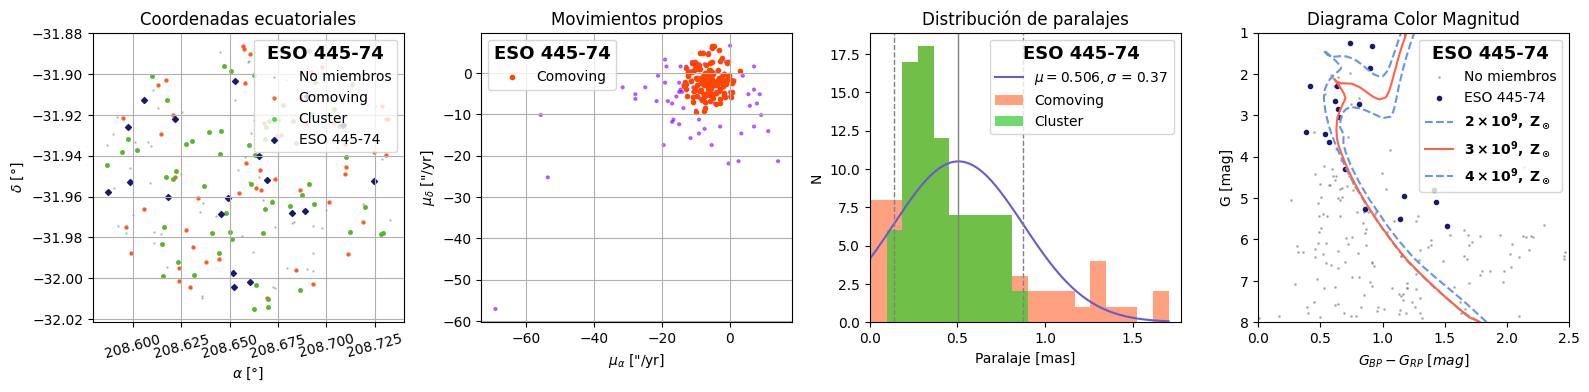

In [42]:
plt.figure(figsize=(16,4))

####################################
plt.subplot(1,4,1)

#RA vs DEC
plt.grid()
plt.scatter(df['ra'],df['dec'], s=0.5, c='grey', alpha=0.5, label= 'No miembros')
plt.scatter(Comoving['ra'], Comoving['dec'], s=5, c='orangered', label='Comoving', alpha=0.7)
plt.scatter(Cluster['ra'], Cluster['dec'], s=7, c='limegreen', label='Cluster', alpha=0.7)
plt.scatter(GD['ra'], GD['dec'], s=9, marker='D', c='midnightblue', label= Cumulo)
plt.xlabel(r'$\alpha$ [°]')
plt.xticks(rotation=15)
plt.ylabel(r'$\delta$ [°]')
plt.legend(title= Cumulo, title_fontproperties={'weight' : 'bold',  'size':13}, loc='upper right')
plt.title('Coordenadas ecuatoriales')

#####################################
plt.subplot(1,4,2)

#Mov. propios alpha y delta
plt.grid()
plt.hexbin(x=df['pmra'],y=df['pmdec'],gridsize=100, cmap='rainbow', mincnt=1, alpha=0.5)
plt.scatter(Comoving['pmra'], Comoving['pmdec'], c='orangered', marker='.', label='Comoving')
plt.xlabel(r'$\mu_{\alpha}$ ["/yr]')
plt.ylabel(r'$\mu_{\delta}$ ["/yr]')
plt.legend(title=Cumulo, title_fontproperties={'weight' : 'bold',  'size':13})
plt.title('Movimientos propios')

######################################
plt.subplot(1,4,3)

#Paralajes:

# Primero crear bines para ambas distribuciones:
# Calcular el rango combinado
minimo = min(Comoving_corte['parallax'].min(), Cluster['parallax'].min())
maximo = max(Comoving_corte['parallax'].max(), Cluster['parallax'].max())

# Crear bins comunes
bins = np.linspace(minimo, maximo, num_bins)

# Ajustar la altura de la curva gaussiana a la escala del histograma
# Número total de datos multiplicado por el ancho de los bins
altura_total = len(Comoving_corte['parallax']) * (bins[1] - bins[0])

# Crear un rango de valores para la curva ajustada
x = np.linspace(min(Comoving_corte['parallax']), max(Comoving_corte['parallax']), 1000)

# Crear la curva gaussiana escalada
pdf_ajustada = norm.pdf(x, media, sigma) * altura_total

#Gráfico de histogramas
plt.plot(x, pdf_ajustada, c='slateblue', label=fr'$\mu= {round(media, 3)}, \sigma$ = {round(sigma, 3)}')
plt.axvline(x=media, ls='-', lw='1', c='grey')
plt.axvline(x=(media-sigma), ls='--', lw='1', c='grey')
plt.axvline(x=(media+sigma), ls='--', lw='1', c='grey')
plt.hist(Comoving_corte['parallax'], label='Comoving', color='orangered', bins=bins, alpha=0.5)
plt.hist(Cluster['parallax'], label='Cluster', color='limegreen', bins=bins, alpha=0.7)
plt.xlabel('Paralaje [mas]')
plt.ylabel('N')
plt.xlim(0, 2*media0)
plt.legend(title=Cumulo, title_fontproperties={'weight' : 'bold',  'size':13}, loc='upper right')
plt.title('Distribución de paralajes')

######################################
plt.subplot(1,4,4)

#DCM
plt.scatter(df['bp_rp']-enroj, df['phot_g_mean_mag']-mod_dist, s=1, c='gray', label='No miembros', alpha=0.5)
plt.scatter(GD['bp_rp']-enroj, GD['phot_g_mean_mag']-mod_dist, s=9, c='midnightblue', label=Cumulo)
plt.plot((envol1['G_BPmag']-envol1['G_RPmag']), envol1['Gmag'], linestyle='--', c='cornflowerblue', label=Error1)
plt.plot((ajuste['G_BPmag']-ajuste['G_RPmag']), ajuste['Gmag'], c='tomato', label=Isocrona)
plt.plot((envol2['G_BPmag']-envol2['G_RPmag']), envol2['Gmag'], linestyle='--', c='cornflowerblue', label=Error2)
plt.xlabel(r"$G_{BP}-G_{RP} \ [mag]$")
plt.ylabel('G [mag]')
plt.gca().invert_yaxis()
plt.xlim(x1, x2)
plt.ylim(y1, y2)
plt.legend(title=Cumulo, title_fontproperties={'weight' : 'bold',  'size':13}, loc='upper right')
plt.title('Diagrama Color Magnitud')


plt.tight_layout()

#plt.savefig(f'{Cumulo}/graf_{Cumulo}_r3.5.png')

# El Diagrama Color-Magnitud

Text(0.5, 1.0, 'ESO 445-74')

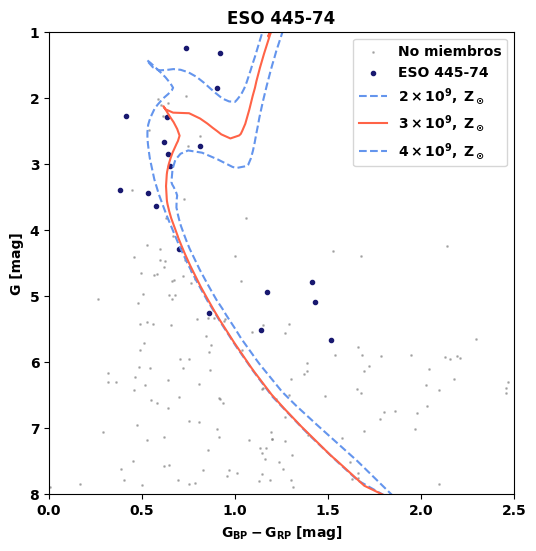

In [43]:
#Para guardar DCM (CAMBIAR NOMBRE ARCHIVO en caso de ser necesario):

plt.figure(figsize=(6,6))
plt.scatter(df['bp_rp']-enroj, df['phot_g_mean_mag']-mod_dist, s=1, c='gray', label='No miembros', alpha=0.5)
plt.scatter(GD['bp_rp']-enroj, GD['phot_g_mean_mag']-mod_dist, s=9, c='midnightblue', label=Cumulo)
plt.plot((envol1['G_BPmag']-envol1['G_RPmag']), envol1['Gmag'], linestyle='--', c='cornflowerblue', label=Error1)
plt.plot((ajuste['G_BPmag']-ajuste['G_RPmag']), ajuste['Gmag'], c='tomato', label=Isocrona)
plt.plot((envol2['G_BPmag']-envol2['G_RPmag']), envol2['Gmag'], linestyle='--', c='cornflowerblue', label=Error2)
plt.xlabel(r"$\mathbf{G_{BP}-G_{RP} \ [mag]}$")
plt.ylabel('G [mag]', fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.gca().invert_yaxis()
plt.xlim(x1, x2)
plt.ylim(y1, y2)
plt.legend(loc='upper right', prop={'weight' : 'bold'})
plt.title(Cumulo, fontweight='bold')

#plt.savefig(f'{Cumulo}/DCM_{Cumulo}_r3.5.png')

# Movimientos propios

Text(0.5, 1.0, 'Movimientos propios')

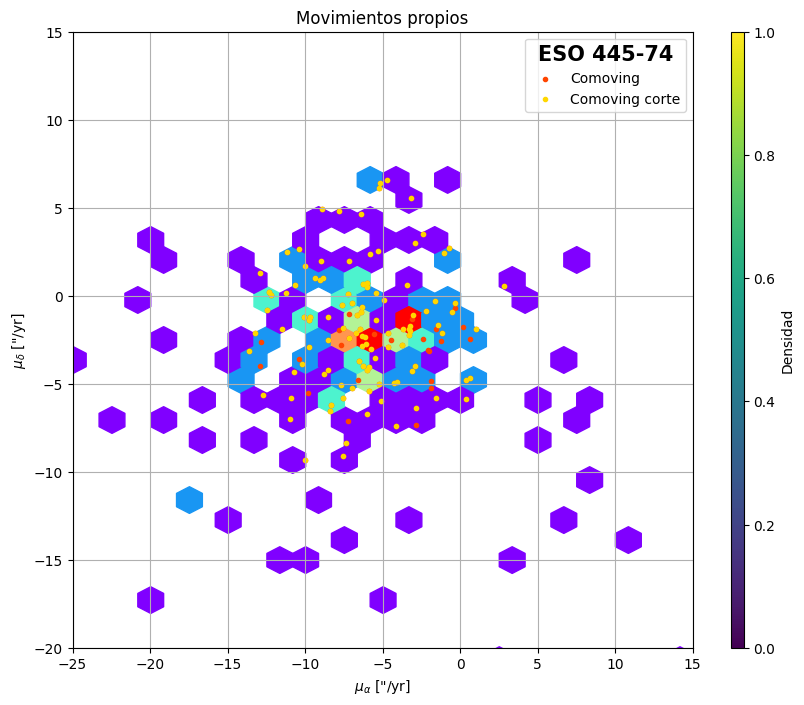

In [44]:
#Mov. propios alpha y delta

plt.figure(figsize=(10,8))
plt.hexbin(x=df['pmra'],y=df['pmdec'],gridsize=50, cmap='rainbow', mincnt=1)
plt.scatter(Comoving['pmra'], Comoving['pmdec'], c='orangered', marker='.', label='Comoving')
plt.scatter(Comoving_corte['pmra'], Comoving_corte['pmdec'], c='gold', marker='.', label='Comoving corte')
plt.xlabel(r'$\mu_{\alpha}$ ["/yr]')
plt.ylabel(r'$\mu_{\delta}$ ["/yr]')
plt.grid()
plt.xlim(-25,15)
plt.ylim(-20,15)
plt.legend(title=Cumulo, title_fontproperties={'weight' : 'bold',  'size':15})
plt.colorbar(label='Densidad', aspect=50)
plt.title('Movimientos propios')

#plt.savefig(f'{Cumulo}/Mov_Prop_{Cumulo}_r3.5.png')

# Paralajes

Para la districubión de paralajes en el rango [0, 1.773] se tiene:
Media: 0.506, Desviación estándar: 0.37
Se define al conjunto GD en el rango [0.135, 0.876]


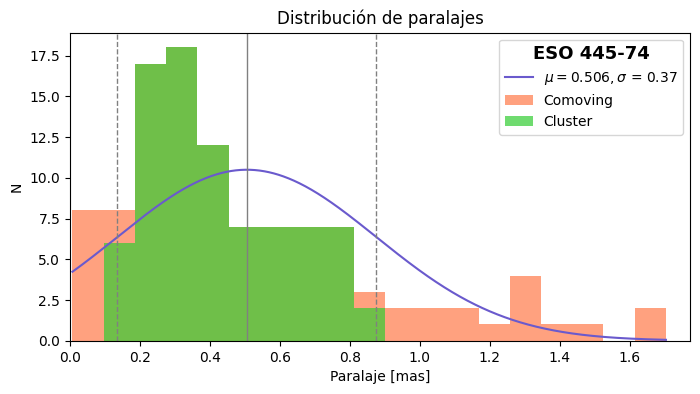

In [45]:
print(f"Para la districubión de paralajes en el rango [0, {round(2 * media0, 3)}] se tiene:")
print(f"Media: {round(media, 3)}, Desviación estándar: {round(sigma, 3)}")

# Primero crear bines para ambas distribuciones:
# Calcular el rango combinado
minimo = min(Comoving_corte['parallax'].min(), Cluster['parallax'].min())
maximo = max(Comoving_corte['parallax'].max(), Cluster['parallax'].max())

# Crear bins comunes
n_bins = 20  #definir cantidad de bines
bins_mult = np.linspace(minimo, maximo, n_bins)

# Ajustar la altura de la curva gaussiana a la escala del histograma
# Número total de datos multiplicado por el ancho de los bins
altura_total = len(Comoving_corte['parallax']) * (bins_mult[1] - bins_mult[0])

# Crear un rango de valores para la curva ajustada
x = np.linspace(min(Comoving_corte['parallax']), max(Comoving_corte['parallax']), 1000)

# Crear la curva gaussiana escalada
pdf_ajustada = norm.pdf(x, media, sigma) * altura_total

#Gráfico de histogramas con ajuste gaussiano
plt.figure(figsize=(8,4))

plt.plot(x, pdf_ajustada, c='slateblue', label=fr'$\mu= {round(media, 3)}, \sigma$ = {round(sigma, 3)}')
plt.axvline(x=media, ls='-', lw='1', c='grey')
plt.axvline(x=(media-sigma), ls='--', lw='1', c='grey')
plt.axvline(x=(media+sigma), ls='--', lw='1', c='grey')
plt.hist(Comoving_corte['parallax'], label='Comoving', color='orangered', bins=bins_mult, alpha=0.5)
plt.hist(Cluster['parallax'], label='Cluster', color='limegreen', bins=bins_mult, alpha=0.7)
plt.xlabel('Paralaje [mas]')
plt.ylabel('N')
plt.xlim(0, 2*media0)
plt.legend(title=Cumulo, title_fontproperties={'weight' : 'bold',  'size':13}, loc='upper right')
plt.title('Distribución de paralajes')

print(f'Se define al conjunto GD en el rango [{round(media-sigma, 3)}, {round(media+sigma, 3)}]')

# Variación de parámetros en los ejes del DCM

Text(0.5, 1.0, 'ESO 445-74')

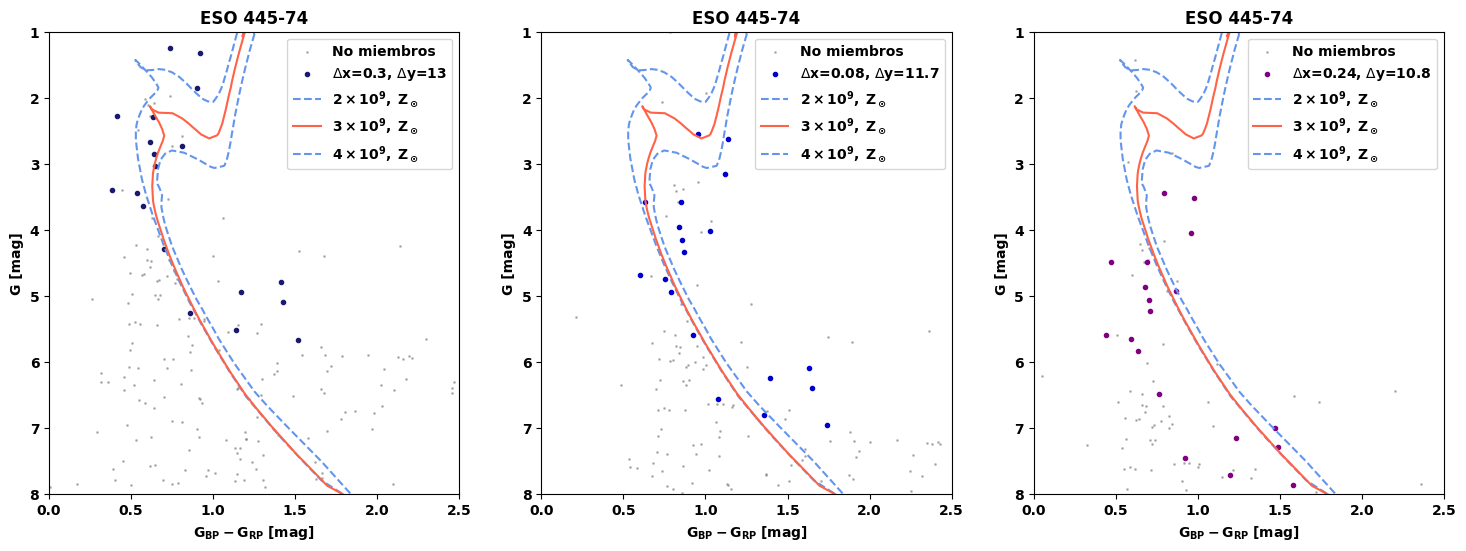

In [46]:
#Para comparar:

plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.scatter(df['bp_rp']-enroj, df['phot_g_mean_mag']-mod_dist, s=1, c='gray', label='No miembros', alpha=0.5)
plt.scatter(GD['bp_rp']-enroj, GD['phot_g_mean_mag']-mod_dist, s=9, c='midnightblue', label=fr'$\Delta$x={enroj}, $\Delta$y={mod_dist}')
plt.plot((envol1['G_BPmag']-envol1['G_RPmag']), envol1['Gmag'], linestyle='--', c='cornflowerblue', label=Error1)
plt.plot((ajuste['G_BPmag']-ajuste['G_RPmag']), ajuste['Gmag'], c='tomato', label=Isocrona)
plt.plot((envol2['G_BPmag']-envol2['G_RPmag']), envol2['Gmag'], linestyle='--', c='cornflowerblue', label=Error2)
plt.xlabel(r"$\mathbf{G_{BP}-G_{RP} \ [mag]}$")
plt.ylabel('G [mag]', fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.gca().invert_yaxis()
plt.xlim(x1, x2)
plt.ylim(y1, y2)
plt.legend(loc='upper right', prop={'weight' : 'bold'})
plt.title(Cumulo, fontweight='bold')

################################################################################################
dx1 = 0.08
dy1 = mod_dist - 1.3

plt.subplot(1,3,2)
plt.scatter(df['bp_rp']-dx1, df['phot_g_mean_mag']-dy1, s=1, c='gray', label='No miembros', alpha=0.5)
plt.scatter(GD['bp_rp']-dx1, GD['phot_g_mean_mag']-dy1, s=9, c='mediumblue', label=fr'$\Delta$x={dx1}, $\Delta$y={dy1}')
plt.plot((envol1['G_BPmag']-envol1['G_RPmag']), envol1['Gmag'], linestyle='--', c='cornflowerblue', label=Error1)
plt.plot((ajuste['G_BPmag']-ajuste['G_RPmag']), ajuste['Gmag'], c='tomato', label=Isocrona)
plt.plot((envol2['G_BPmag']-envol2['G_RPmag']), envol2['Gmag'], linestyle='--', c='cornflowerblue', label=Error2)
plt.xlabel(r"$\mathbf{G_{BP}-G_{RP} \ [mag]}$")
plt.ylabel('G [mag]', fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.gca().invert_yaxis()
plt.xlim(x1, x2)
plt.ylim(y1, y2)
plt.legend(loc='upper right', prop={'weight' : 'bold'})
plt.title(Cumulo, fontweight='bold')

################################################################################################
dx2 = enroj -0.06
dy2 = mod_dist +0.3-2.5

plt.subplot(1,3,3)
plt.scatter(df['bp_rp']-dx2, df['phot_g_mean_mag']-dy2, s=1, c='gray', label='No miembros', alpha=0.5)
plt.scatter(GD['bp_rp']-dx2, GD['phot_g_mean_mag']-dy2, s=9, c='purple', label=fr'$\Delta$x={dx2}, $\Delta$y={dy2}')
plt.plot((envol1['G_BPmag']-envol1['G_RPmag']), envol1['Gmag'], linestyle='--', c='cornflowerblue', label=Error1)
plt.plot((ajuste['G_BPmag']-ajuste['G_RPmag']), ajuste['Gmag'], c='tomato', label=Isocrona)
plt.plot((envol2['G_BPmag']-envol2['G_RPmag']), envol2['Gmag'], linestyle='--', c='cornflowerblue', label=Error2)
plt.xlabel(r"$\mathbf{G_{BP}-G_{RP} \ [mag]}$")
plt.ylabel('G [mag]', fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.gca().invert_yaxis()
plt.xlim(x1, x2)
plt.ylim(y1, y2)
plt.legend(loc='upper right', prop={'weight' : 'bold'})
plt.title(Cumulo, fontweight='bold')

#plt.savefig(f'{Cumulo}/Comp_ejes_{Cumulo}_N27.png')

# Variar isócronas

Text(0.5, 1.0, 'ESO 445-74')

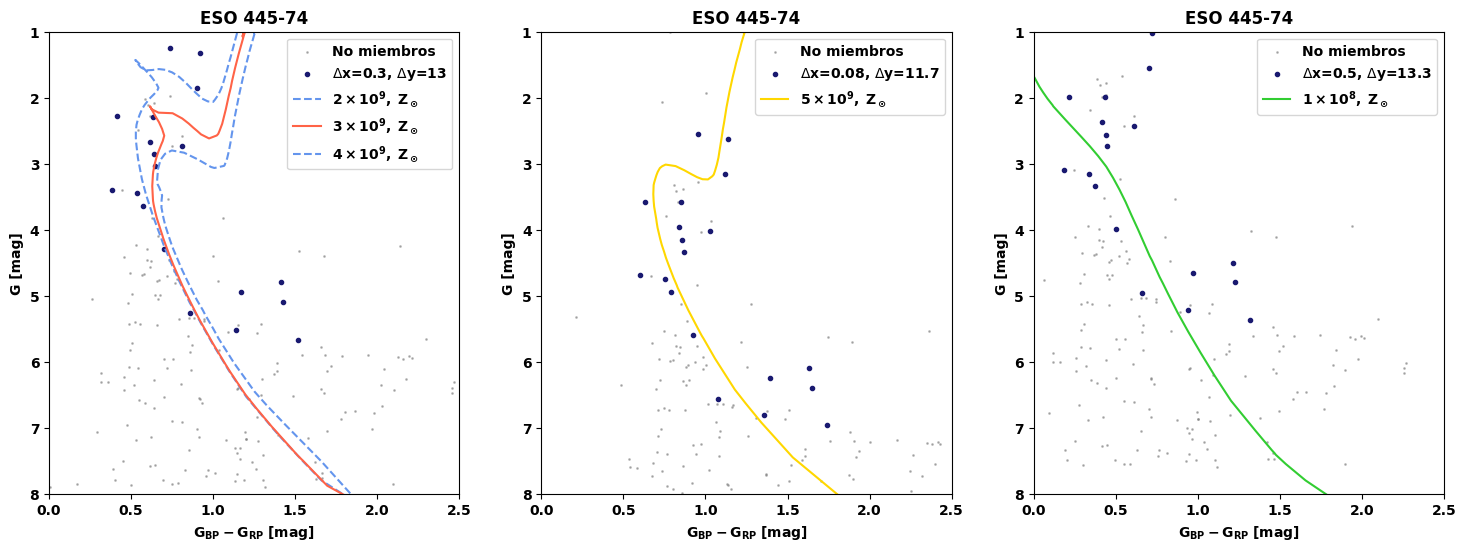

In [55]:
#Para comparar:

plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.scatter(df['bp_rp']-enroj, df['phot_g_mean_mag']-mod_dist, s=1, c='gray', label='No miembros', alpha=0.5)
plt.scatter(GD['bp_rp']-enroj, GD['phot_g_mean_mag']-mod_dist, s=9, c='midnightblue', label=fr'$\Delta$x={enroj}, $\Delta$y={mod_dist}')
plt.plot((envol1['G_BPmag']-envol1['G_RPmag']), envol1['Gmag'], linestyle='--', c='cornflowerblue', label=Error1)
plt.plot((ajuste['G_BPmag']-ajuste['G_RPmag']), ajuste['Gmag'], c='tomato', label=Isocrona)
plt.plot((envol2['G_BPmag']-envol2['G_RPmag']), envol2['Gmag'], linestyle='--', c='cornflowerblue', label=Error2)
plt.xlabel(r"$\mathbf{G_{BP}-G_{RP} \ [mag]}$")
plt.ylabel('G [mag]', fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.gca().invert_yaxis()
plt.xlim(x1, x2)
plt.ylim(y1, y2)
plt.legend(loc='upper right', prop={'weight' : 'bold'})
plt.title(Cumulo, fontweight='bold')

#################################### PRUEBA 1 ####################################
Isocrona1 = r'$\mathbf{5 \times10^9, \ Z_\odot}$'  #nombre isócrona de prueba1
#Error1_1   = r'$\mathbf{1.5 \times10^9, \ Z_\odot}$'
#Error2_1   = r'$\mathbf{2.5 \times10^9, \ Z_\odot}$'
ajuste1 = isocronas['5_9-0.0152_tabla.dat']
#envol1_1 = isocronas['']
#envol2_1 = isocronas['']

dx1 = 0.08
dy1 = mod_dist -1.3

plt.subplot(1,3,2)
plt.scatter(df['bp_rp']-dx1, df['phot_g_mean_mag']-dy1, s=1, c='gray', label='No miembros', alpha=0.5)
plt.scatter(GD['bp_rp']-dx1, GD['phot_g_mean_mag']-dy1, s=9, c='midnightblue', label=fr'$\Delta$x={dx1}, $\Delta$y={dy1}')
#plt.plot((envol1_1['G_BPmag']-envol1_1['G_RPmag']), envol1_1['Gmag'], linestyle='--', c='cornflowerblue', label=Error1_1)
plt.plot((ajuste1['G_BPmag']-ajuste1['G_RPmag']), ajuste1['Gmag'], c='gold', label=Isocrona1)
#plt.plot((envol2_1['G_BPmag']-envol2_1['G_RPmag']), envol2_1['Gmag'], linestyle='--', c='cornflowerblue', label=Error2_1)
plt.xlabel(r"$\mathbf{G_{BP}-G_{RP} \ [mag]}$")
plt.ylabel('G [mag]', fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.gca().invert_yaxis()
plt.xlim(x1, x2)
plt.ylim(y1, y2)
plt.legend(loc='upper right', prop={'weight' : 'bold'})
plt.title(Cumulo, fontweight='bold')


#################################### PRUEBA 2 ####################################
Isocrona2 = r'$\mathbf{1 \times10^8, \ Z_\odot}$'  #nombre isócrona de prueba2
#Error1_2   = r'$\mathbf{1.5 \times10^9, \ Z_\odot}$'
#Error2_2   = r'$\mathbf{2.5 \times10^9, \ Z_\odot}$'
ajuste2 = isocronas['1_8-0.0152_tabla.dat']
#envol1_2 = isocronas['']
#envol2_2 = isocronas['']

#en caso de necesitar, refedinir:
ajuste2 = ajuste2[ ((ajuste2['G_BPmag']-ajuste2['G_RPmag']) <2.5) & (ajuste2['Gmag'] >-6) & (ajuste2['Gmag'] <12) ]

dx2= 0.5
dy2= 13.3

plt.subplot(1,3,3)
plt.scatter(df['bp_rp']-dx2, df['phot_g_mean_mag']-dy2, s=1, c='gray', label='No miembros', alpha=0.5)
plt.scatter(GD['bp_rp']-dx2, GD['phot_g_mean_mag']-dy2, s=9, c='midnightblue', label=fr'$\Delta$x={dx2}, $\Delta$y={dy2}')
#plt.plot((envol1_2['G_BPmag']-envol1_2['G_RPmag']), envol1_2['Gmag'], linestyle='--', c='cornflowerblue', label=Error1_2)
plt.plot((ajuste2['G_BPmag']-ajuste2['G_RPmag']), ajuste2['Gmag'], c='limegreen', label=Isocrona2)
#plt.plot((envol2_2['G_BPmag']-envol2_2['G_RPmag']), envol2_2['Gmag'], linestyle='--', c='cornflowerblue', label=Error2_2)
plt.xlabel(r"$\mathbf{G_{BP}-G_{RP} \ [mag]}$")
plt.ylabel('G [mag]', fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.gca().invert_yaxis()
plt.xlim(x1, x2)
plt.ylim(y1, y2)
plt.legend(loc='upper right', prop={'weight' : 'bold'})
plt.title(Cumulo, fontweight='bold')


In [48]:
for nombre, tabla in isocronas.items():
    print(f"Isócrona: {nombre}")

Isócrona: 1_8-0.0152_tabla.dat
Isócrona: 1.8_9-0.0152_tabla.dat
Isócrona: 1_9-0.001_tabla.dat
Isócrona: 4_9-0.0152_tabla.dat
Isócrona: 2_9-0.0152_tabla.dat
Isócrona: 2.5_9-0.0152_tabla.dat
Isócrona: 5_9-0.0152_tabla.dat
Isócrona: 7_8-0.0152_tabla.dat
Isócrona: 2.5_8-0.0152_tabla.dat
Isócrona: 2_9-0.001_tabla.dat
Isócrona: 3_9-0.0152_tabla.dat
Isócrona: 1.5_9-0.0152_tabla.dat
Isócrona: 2_8-0.03_tabla.dat
Isócrona: 1_7-0.0152_tabla.dat
Isócrona: 2_8-0.0152_tabla.dat
Isócrona: 3_8-0.03_tabla.dat
Isócrona: 1_7-0.03_tabla.dat
Isócrona: 1_8-0.02_tabla.dat
Isócrona: 3_7-0.03_tabla.dat
Isócrona: 5_7-0.03_tabla.dat
Isócrona: 1_9-0.02_tabla.dat
Isócrona: 5_8-0.0152_tabla.dat
Isócrona: 1_8-0.03_tabla.dat
Isócrona: 1.5_8-0.0152_tabla.dat
Isócrona: 3_8-0.0152_tabla.dat
Isócrona: 5_7-0.0152_tabla.dat
Isócrona: 3_9-0.001_tabla.dat
Isócrona: 1_9-0.0152_tabla.dat
Isócrona: 1_9-0.01_tabla.dat
Isócrona: 1_9-0.03_tabla.dat
Isócrona: 3_7-0.0152_tabla.dat
Isócrona: 2_9-0.03_tabla.dat
Isócrona: 1.5_9-0.03_ta